# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


# Data Cleaning

In [8]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

#Drop customerID (not useful for Clustering)
df.drop(['customerID'], axis = 1, inplace = True)

# Feature Engineering

In [9]:
# Count of All Services Used
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['ServiceCount'] = df[service_cols].apply(lambda x: sum(x != 0), axis = 1)

# Average Monthly Spend
df['AverageMonthlySpend'] = df['TotalCharges']/(df['tenure'] + 1)

# Family Indicator
yes_no_cols = ['Partner', 'Dependents']
for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
    
df['IsFamily'] = (df['Partner'] + df['Dependents']).apply(lambda x: 1 if x>0 else 0)

In [10]:
df.tail(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ServiceCount,AverageMonthlySpend,IsFamily
7040,Female,0,1,1,11,No,No phone service,DSL,Yes,No,...,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,9,28.870833,1
7041,Male,1,1,0,4,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,9,61.320000,1
7042,Male,0,0,0,66,Yes,No,Fiber optic,Yes,No,...,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No,9,102.156716,0


# Encode Categorical Columns

In [11]:
cat_cols = df.select_dtypes(include = 'object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [12]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

In [13]:
df[cat_cols].head(2)

,gender,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,1,0,0,2,0,2,0,0,0,1,0,3,0


# Scaling

In [14]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.drop('Churn', axis = 1))

In [15]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ServiceCount,AverageMonthlySpend,IsFamily
0,0,0,1,0,1,0,1,0,0,2,...,0,0,1,2,29.85,29.85,0,9,14.925000,1
1,1,0,0,0,34,1,0,0,2,0,...,0,1,0,3,56.95,1889.50,0,9,53.985714,0
2,1,0,0,0,2,1,0,0,2,2,...,0,0,1,3,53.85,108.15,1,9,36.050000,0
3,1,0,0,0,45,0,1,0,2,0,...,0,1,0,0,42.30,1840.75,0,9,40.016304,0
4,0,0,0,0,2,1,0,1,0,0,...,0,0,1,2,70.70,151.65,1,9,50.550000,0


# Find Optimal Clusters (Elbow + Silhouette)

In [16]:
inertia = []
sil_scores = []

K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_df)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(scaled_df, labels)) 

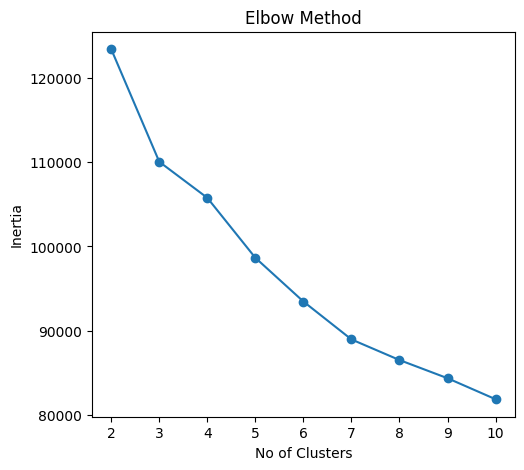

In [17]:
# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("No of Clusters")
plt.ylabel("Inertia")
plt.show()

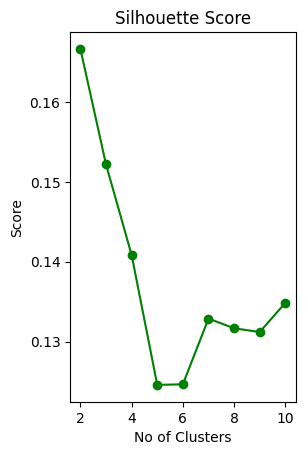

In [18]:
# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("No of Clusters")
plt.ylabel("Score")
plt.show()

# Apply KMeans Clustering

In [19]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_df)

In [20]:
# Numeric summary
cluster_summary = df.groupby('Cluster').mean()[['tenure','MonthlyCharges','TotalCharges',
                                                 'ServiceCount','AverageMonthlySpend','Churn']]
cluster_summary

,tenure,MonthlyCharges,TotalCharges,ServiceCount,AverageMonthlySpend,Churn
Cluster,,,,,,
0,30.774775,41.478529,1424.077477,9.0,37.866267,0.255255
1,16.714050,58.779666,922.220705,9.0,48.979507,0.374536
2,54.978922,94.609853,5195.838922,9.0,92.671871,0.187255
3,28.676440,48.601859,1196.525798,9.0,43.456064,0.213613


In [21]:
# Categorical summary
cat_summary = df.groupby('Cluster')[cat_cols].agg(lambda x: x.value_counts().index[0])
cat_summary

,gender,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
Cluster,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,0,1,2,0
1,1,1,0,1,0,0,0,0,0,0,0,1,2,0
2,1,1,2,1,2,2,2,2,2,2,2,1,2,0
3,1,1,0,2,1,1,1,1,1,1,0,0,3,0


# Visualize Clusters (PCA 2D)

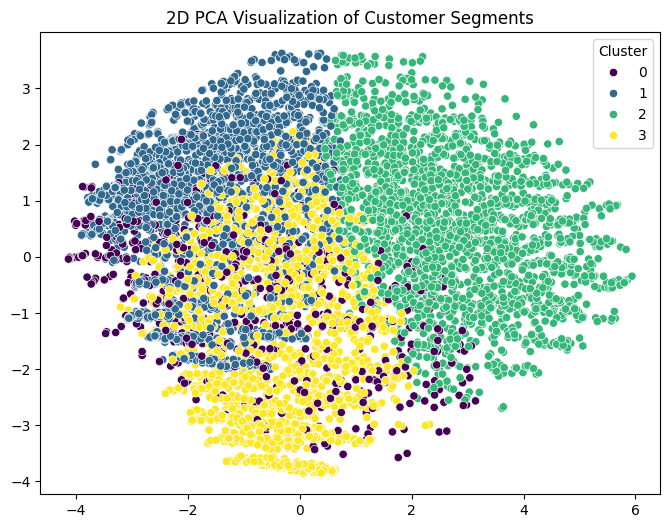

In [22]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=df['Cluster'], palette='viridis')
plt.title("2D PCA Visualization of Customer Segments")
plt.show()

In [23]:
# Which cluster has highest churn
churn_by_cluster = df.groupby('Cluster')['Churn'].mean()
churn_by_cluster

Cluster
0    0.255255
1    0.374536
2    0.187255
3    0.213613
Name: Churn, dtype: float64

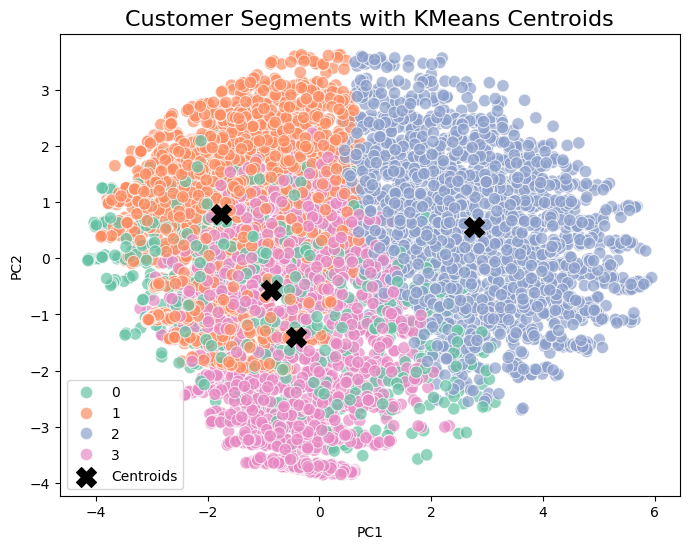

In [24]:
# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=df['Cluster'], palette='Set2', s=80, alpha=0.7)

# Plot centroids
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)  # transform centroids into PCA space
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=200, marker='X', label='Centroids')

plt.title("Customer Segments with KMeans Centroids", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

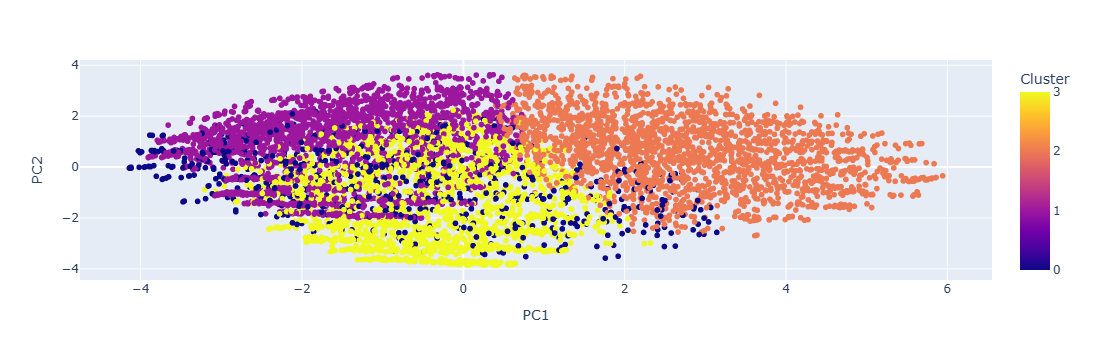

In [25]:
import plotly.express as px
df['PC1'] = components[:,0]
df['PC2'] = components[:,1]
fig = px.scatter(df, x='PC1', y='PC2', color='Cluster', hover_data=['MonthlyCharges','tenure'])
fig.show()

# Feature importance per cluster

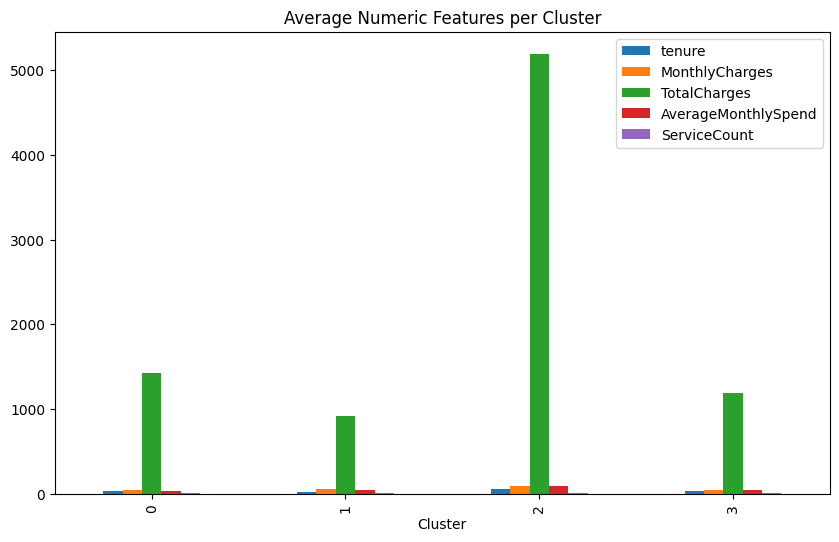

In [26]:
cluster_means = df.groupby('Cluster').mean()
cluster_means[['tenure','MonthlyCharges','TotalCharges','AverageMonthlySpend','ServiceCount']].plot(kind='bar', figsize=(10,6))
plt.title("Average Numeric Features per Cluster")
plt.show()

# Distribution of categorical variables

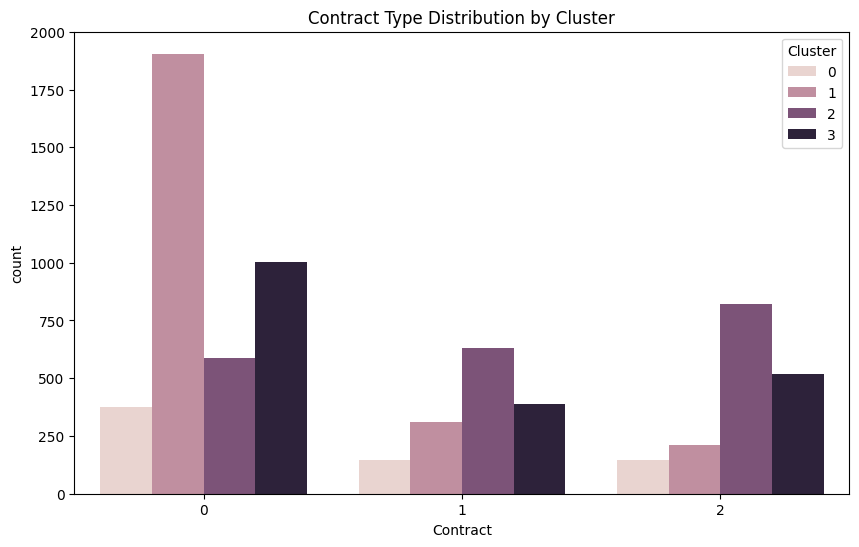

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(x='Contract', hue='Cluster', data=df)
plt.title("Contract Type Distribution by Cluster")
plt.show()